# Building ePSF Model for GSC02581

In [1]:
#loading the image of GSC02581

import astropy
from astropy.io import fits
from astropy.io.fits import HDUList

import pathlib
import path

fits_image_GSC02581 = astropy.io.fits.open(pathlib.Path('Documents', 'research','unpacked_hst_data','GSC02581','ie6y54010_drz.fits'))

hdul = fits_image_GSC02581

image_data = fits.getdata('Documents/research/unpacked_hst_data/GSC02581/ie6y54010_drz.fits', ext=0)

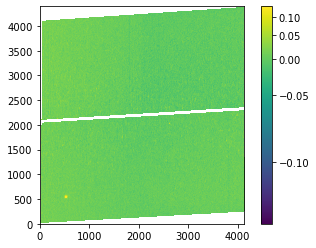

In [2]:
#visualize the image

import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

norm = simple_norm(image_data, 'asinh', percent=99.)
plt.imshow(image_data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

In [3]:
#find stars

from photutils.detection import find_peaks

peaks_tbl = find_peaks(image_data, threshold=400.)  
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output  
print(peaks_tbl)

x_peak y_peak peak_value
------ ------ ----------
   524    549  404.71954
   254   4132  802.89087
   254   4133  802.89087


In [4]:
#choosing stars

size = 25
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
mask = ((x > hsize) & (x < (image_data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (image_data.shape[0] -1 - hsize)))


#table of good star positions

from astropy.table import Table

stars_tbl = Table()
stars_tbl['x'] = x[mask]  
stars_tbl['y'] = y[mask]
print(stars_tbl)

 x   y  
--- ----
524  549
254 4132
254 4133


In [5]:
#subtract background

from astropy.stats import sigma_clipped_stats
mean_val, median_val, std_val = sigma_clipped_stats(image_data, sigma=2.)  
image_data -= median_val 

from astropy.nddata import NDData
nd_image_data = NDData(data=image_data) 

In [6]:
#extract stars

from photutils.psf import extract_stars
stars = extract_stars(nd_image_data, stars_tbl, size=25) 

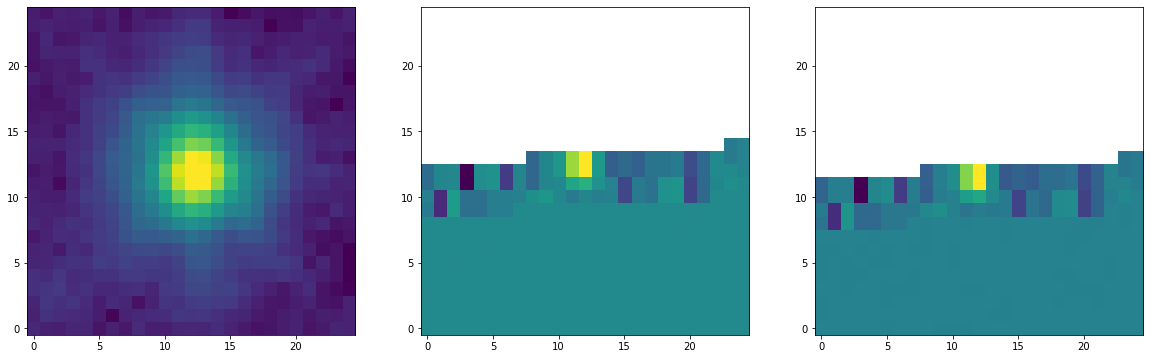

In [30]:
#plot the extracted stars

import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

nrows = 1
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                        squeeze=True)
#cmaps = ['viridis', 'viridis', 'viridis']
ax = ax.ravel()
for i in range(nrows*ncols):
     norm = simple_norm(stars[i], 'log', percent=99.)
     ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
#     fig.colorbar(ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis'), ax=ax[i])

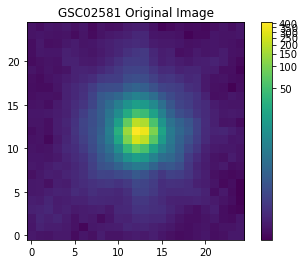

In [46]:
#plotting GSC02581 alone
norm = simple_norm(stars[0], 'log', 99.)
plt.imshow(stars[0], norm=norm, origin='lower', cmap='viridis')
plt.title('GSC02581 Original Image')
plt.colorbar()

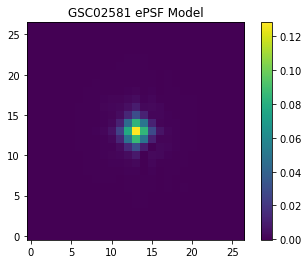

In [56]:
#building the ePSF

from photutils.psf import EPSFBuilder

epsf_builder = EPSFBuilder(oversampling=1, maxiters=15, shape = None, smoothing_kernel = 'quartic',
                            progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars[0])

import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
#norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, origin='lower', cmap='viridis')
plt.title('GSC02581 ePSF Model')
plt.colorbar()

In [32]:
epsf.data.resize((25,25))
epsf.data.shape

(25, 25)

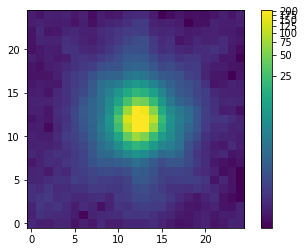

In [33]:
residual_image = stars[0] - epsf.data

norm = simple_norm(residual_image, 'log', percent=99.)
plt.imshow(residual_image, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()